# A Demo of ForcePhotZTF

This is a demo of how to use the code to get forced photometry light curve for [ZTF19aadyppr (Jencson et al. 2019)](https://arxiv.org/abs/1904.07857), an itermediate luminosity red transient (ILRT) in M51 discovered by ZTF! </br>

First, let's import some packages.<br>
Remember to add the parent path of ForcePhotZTF to your system, I use the command `sys.path.append()` for this purpose.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

import sys
sys.path.append('/Users/yuhanyao/Documents/')

In [2]:
from ForcePhotZTF.keypairs import get_keypairs
from ForcePhotZTF.force_lc import download_marshal_lightcurve, get_coo_ZTFtarget, astrometry_spread, \
                                    get_cutout_data, download_images_diffpsf_refdiff
from ForcePhotZTF.force_mcmc import get_forced_phot_mcmc
from ForcePhotZTF.refine_lc import get_recerence_jds, plotlcs, read_ipac_lc, read_mcmc_lc

This demo utilized the package `multiprocessing`. You need to specify how many cores you want to use to extract the light curve (`ncpu`). Here I use the total number of cores in my laptop. 

In [3]:
from multiprocessing import cpu_count
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

12 CPUs


In [4]:
# name your transient: can be a ZTFname or anything you want
name = 'ZTF19aadyppr'
# provide the directory under which you want to score all of your data
targetdir = os.getcwd() + '/' + name + '/'

In [5]:
targetdir

'/Users/yuhanyao/Documents/ForcePhotZTF/ZTF19aadyppr/'

## 1.  Download marshal lightcurve and get a sense of the lightcurve    

In [7]:
download_marshal_lightcurve(name, targetdir)

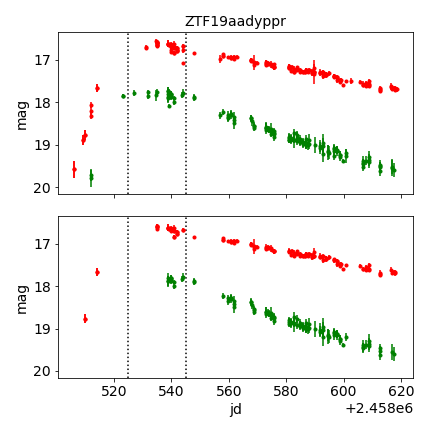

In [8]:
from IPython.core.display import Image 
Image(filename=targetdir+'marshal_lc_plot'+name+'.png',width=500)

This is the marshal light curve of this source (Patterson et al. 2019; Masci et al. 2019). r band obs in red; g band obs in green. 

The upper panel shows all data points (including public data). The bottom panel shows all data points except for public data (which means partnership data + Caltech data). [Public data in 2018](https://www.ztf.caltech.edu/news/public-data-release-1) has been released on May 8th, 2019. __For Caltech users__: if most of your photometry are from the 2019 public program, running forced photometry may not be very useful.

## 2. Get the coordinate of the source
- If you already know the coordinate of your transient, then skip this step.

- If you want to get the coornidate based on the ZTF name, then run:

In [9]:
get_coo_ZTFtarget(name, targetdir)

In [10]:
# this is the coordinate on marshal webpage
ra1, dec1 = np.loadtxt(targetdir+'coo_marshal.reg') 

# this is the recentered coordiante by taking the median of all detections from the alert packets
ra2, dec2 = np.loadtxt(targetdir+'coo_kowalski.reg') 

Now let's look at the difference between the recentered coordinate and the marshal coordinate.

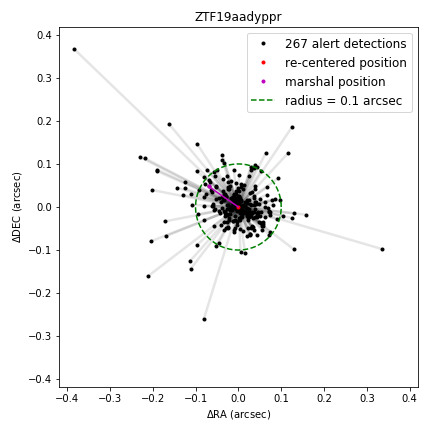

In [11]:
astrometry_spread(name, targetdir)
Image(filename=targetdir+'astrometry.png',width=400)

Although the difference is tiny: < 0.1 arcsec, the re-centered position is more accurate. We'll use that!

In [11]:
ra = ra2
dec = dec2

## 3. Download images from IRSA database
Download images from ipac (psfmodel image and difference image, ~5GB each target) using a corss-match radius of 36 arcsecs (0.01 deg, which is very conservative). 

In [14]:
download_images_diffpsf_refdiff(targetdir, ra, dec)



Querying for metadata...
Trying to download 855 images from irsa...
In progress: 0 in 855
In progress: 50 in 855
In progress: 100 in 855
In progress: 150 in 855
In progress: 200 in 855
In progress: 250 in 855
In progress: 300 in 855
In progress: 350 in 855
In progress: 400 in 855
In progress: 450 in 855
In progress: 500 in 855
In progress: 550 in 855
In progress: 600 in 855
In progress: 650 in 855
In progress: 700 in 855
In progress: 750 in 855
In progress: 800 in 855
In progress: 850 in 855
117 images in 855 we do not have data:


checking if all files can be opened...
In progress: 0 in 738...
In progress: 50 in 738...
In progress: 100 in 738...
In progress: 150 in 738...
In progress: 200 in 738...
In progress: 250 in 738...
In progress: 300 in 738...
In progress: 350 in 738...
In progress: 400 in 738...
In progress: 450 in 738...
In progress: 500 in 738...
In progress: 550 in 738...
In progress: 600 in 738...
In progress: 650 in 738...
In progress: 700 in 738...




## 4. Get observation infomation and cutouts.

The default cutout size is a 7x7 pixel square, where 7 = 2 x r\_psf + 1. 
Background noise is estimated by taking an annulus with inner radius = 10 pixel, and outer radius = 15 pixel. You can adjust those parameters (although I do not recommend you to do so).
        
Let's save the cutout data and observation information in two fits files.

In [15]:
r_psf = 3
r_bkg_in = 10
r_bkg_out = 15
verbose = False
get_cutout_data(name, targetdir, ra, dec, r_psf = r_psf, 
                r_bkg_in = r_bkg_in, r_bkg_out = r_bkg_out, verbose = verbose)

Start saving cutouts and observation info for ZTF19aadyppr...
In progress ZTF19aadyppr: 0 in 738...
In progress ZTF19aadyppr: 50 in 738...
In progress ZTF19aadyppr: 100 in 738...
In progress ZTF19aadyppr: 150 in 738...
In progress ZTF19aadyppr: 200 in 738...
In progress ZTF19aadyppr: 250 in 738...
In progress ZTF19aadyppr: 300 in 738...
In progress ZTF19aadyppr: 350 in 738...
In progress ZTF19aadyppr: 400 in 738...
In progress ZTF19aadyppr: 450 in 738...
In progress ZTF19aadyppr: 500 in 738...
In progress ZTF19aadyppr: 550 in 738...
In progress ZTF19aadyppr: 600 in 738...
In progress ZTF19aadyppr: 650 in 738...
In progress ZTF19aadyppr: 700 in 738...


writing light curve to database


Now, get the reference epochs (start jd and end jd) for each fcqf ID

In [13]:
get_recerence_jds(name, targetdir, only_partnership=False, retain_iband = True,
                  oldsuffix = '_info.fits', newsuffix = '_info_ref.fits', verbose=True)

Start getting jd of reference exposures for ZTF19aadyppr
fieldid: 757, ccdid: 7, qid: 2, filterid: 2 
 	 startjd: 2458155.98, endjd: 2458186.93 

fieldid: 757, ccdid: 7, qid: 2, filterid: 1 
 	 startjd: 2458166.95, endjd: 2458204.90 

fieldid: 1756, ccdid: 14, qid: 2, filterid: 2 
 	 startjd: 2458155.97, endjd: 2458186.93 

fieldid: 1756, ccdid: 14, qid: 2, filterid: 3 
 	 startjd: 2458155.97, endjd: 2458186.93 

fieldid: 757, ccdid: 7, qid: 2, filterid: 3 
 	 startjd: 2458155.98, endjd: 2458186.93 



## 5. Forced-PSF photometry using MCMC!

__Note__: make sure that your `emcee` package is up to date, otherwise the convergence check could show error(s).<br>
I use 12 cores to run the following function, but as you can see, it still takes quite some time on my computer. <br>
If you need to deal with ~>100 targets, it's probabaly better to set this up in a server.

__ATTENTION__! You should make shure that your emcee version is [3.0rc2](https://emcee.readthedocs.io/en/latest/user/install/)! Otherwise you will run into errors.

You can check this by:

In [1]:
import emcee
emcee.__version__

'3.0rc2'

In [16]:
get_forced_phot_mcmc(name, targetdir, ncpu)

Start fitting PSF using MCMC method for ZTF19aadyppr
index = 4, Fmcmc_med = 24.13
index = 8, Fmcmc_med = 11.68
index = 1, Fmcmc_med = 15.88
index = 7, Fmcmc_med = 9.72
index = 0, Fmcmc_med = -36.34
index = 10, Fmcmc_med = 100.26
index = 6, Fmcmc_med = -0.88
index = 5, Fmcmc_med = 15.95
index = 11, Fmcmc_med = 28.05
index = 2, Fmcmc_med = 11.64
index = 9, Fmcmc_med = -28.70
index = 3, Fmcmc_med = 1.04
index = 12, Fmcmc_med = 20.59
index = 13, Fmcmc_med = -18.17
index = 14, Fmcmc_med = 28.77
index = 16, Fmcmc_med = -1200.86
index = 17, Fmcmc_med = 561.14
index = 18, Fmcmc_med = 35.13
index = 21, Fmcmc_med = -52.60
index = 15, Fmcmc_med = 87.83
index = 20, Fmcmc_med = 9.17
index = 22, Fmcmc_med = -18.86
index = 23, Fmcmc_med = 53.64
index = 19, Fmcmc_med = 22.24
index = 25, Fmcmc_med = -66.32
index = 24, Fmcmc_med = -31.04
index = 26, Fmcmc_med = 61.33
index = 27, Fmcmc_med = 62.66
index = 28, Fmcmc_med = 19.36
index = 29, Fmcmc_med = 53.36
index = 30, Fmcmc_med = -6.66
index = 31, Fmcmc_

index = 261, Fmcmc_med = 9.52
index = 264, Fmcmc_med = 18.19
index = 267, Fmcmc_med = 0.44
index = 265, Fmcmc_med = 11.89
index = 266, Fmcmc_med = 25.07
index = 268, Fmcmc_med = 12.10
index = 269, Fmcmc_med = 2.34
index = 271, Fmcmc_med = 42.11
index = 270, Fmcmc_med = 5.60
index = 272, Fmcmc_med = 38.36
index = 273, Fmcmc_med = -5.94
index = 274, Fmcmc_med = 32.37
index = 275, Fmcmc_med = 36.04
index = 276, Fmcmc_med = 3.37
index = 278, Fmcmc_med = -29.54
index = 277, Fmcmc_med = -1.98
index = 279, Fmcmc_med = -22.92
index = 281, Fmcmc_med = 664.66
index = 282, Fmcmc_med = 253.31
index = 284, Fmcmc_med = 34.15
index = 283, Fmcmc_med = 108.07
index = 280, Fmcmc_med = -21.36
index = 287, Fmcmc_med = 24.16
index = 286, Fmcmc_med = 28.05
index = 285, Fmcmc_med = -287.30
index = 289, Fmcmc_med = 38.42
index = 288, Fmcmc_med = 58.71
index = 291, Fmcmc_med = 17.24
index = 290, Fmcmc_med = 25.83
index = 292, Fmcmc_med = 38.58
index = 293, Fmcmc_med = 20.38
index = 294, Fmcmc_med = 12.56
index

index = 527, Fmcmc_med = 2096.84
index = 525, Fmcmc_med = 2031.59
index = 529, Fmcmc_med = 6526.33
index = 528, Fmcmc_med = 2174.50
index = 530, Fmcmc_med = 1772.61
index = 532, Fmcmc_med = 5669.45
index = 533, Fmcmc_med = 1733.01
index = 534, Fmcmc_med = 1771.10
index = 535, Fmcmc_med = 4488.15
index = 537, Fmcmc_med = 5437.92
index = 536, Fmcmc_med = 4824.07
index = 539, Fmcmc_med = 5799.93
index = 538, Fmcmc_med = 1570.47
index = 540, Fmcmc_med = 5514.62
index = 541, Fmcmc_med = 5564.25
index = 542, Fmcmc_med = 1610.25
index = 543, Fmcmc_med = 1628.74
index = 546, Fmcmc_med = 1478.00
index = 544, Fmcmc_med = 5376.86
index = 545, Fmcmc_med = 1619.87
index = 531, Fmcmc_med = 5494.23
index = 547, Fmcmc_med = 1526.30
index = 548, Fmcmc_med = 1582.25
index = 549, Fmcmc_med = 1514.67
index = 523, Fmcmc_med = 6474.34
index = 552, Fmcmc_med = 5648.14
index = 551, Fmcmc_med = 5558.64
index = 554, Fmcmc_med = 1210.45
index = 553, Fmcmc_med = 5452.27
index = 555, Fmcmc_med = 1464.16
index = 55

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->bytes,key->block1_values] [items->['filter', 'diffimgname', 'psfimgname']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


## 6. Get the forced photometry from IPAC service
This step is optional. We well need two columns to remove outliers.

In [21]:
DEFAULT_AUTHs = get_keypairs()
DEFAULT_AUTH_fps = DEFAULT_AUTHs[3] # IPAC force photometry service username and password
import subprocess
info_file = targetdir+'lightcurves/force_phot_{}_info_ref.fits'.format(name)
# xy_file = targetdir+'lightcurves/xydata_{}.fits'.format(name)

info_tbl = Table.read(info_file)
# xy_tbl = Table.read(xy_file)
info_df = info_tbl.to_pandas()
# xy_df = xy_tbl.to_pandas()

In [22]:
jdstart = np.min(info_df['jdobs'])-31
jdend = np.max(info_df['jdobs'])+31
line = 'wget --http-user='+DEFAULT_AUTH_fps[0]+' --http-passwd=' + DEFAULT_AUTH_fps[1]+\
            ' -q -O log.txt '+ \
            '"https://ztfweb.ipac.caltech.edu/cgi-bin/requestForcedPhotometry.cgi?'+\
            'ra=%.7f&dec=%.7f&jdstart=%.5f&jdend=%.5f&'%(ra, dec, jdstart, jdend)+\
            'email=yyao@astro.caltech.edu"'

In [36]:
subprocess.Popen(line, shell=True)

After a few minutes you should receive an email with a link to download the lightcurve. <br>
You need to donwload the light curve and put it under `targetdir/lightcurves/`.

In [23]:
numstr = "552" # this is from the email that you received

In [24]:
line = 'wget --http-user='+DEFAULT_AUTH_fps[0]+' --http-passwd=' + DEFAULT_AUTH_fps[1]+\
        ' "https://ztfweb.ipac.caltech.edu/ztf/ops/forcedphot/lc/0/0/'+\
        'req'+numstr+'/forcedphotometry_req00000'+numstr+'_lc.txt"'

In [28]:
os.chdir(targetdir + "lightcurves/")

In [33]:
pwd

'/Users/yuhanyao/Documents/ForcePhotZTF/ZTF19aadyppr/lightcurves'

In [30]:
subprocess.Popen(line, shell=True)

Now, rename the IPAC lightcurve to `forcedphotometry_ipac_lc.txt`

In [34]:
line = "mv forcedphotometry_req00000"+numstr+"_lc.txt forcedphotometry_ipac_lc.txt"

In [35]:
subprocess.Popen(line, shell=True)

## 7. Take a quick look at our light curve.

In [12]:
mylc = read_mcmc_lc(name, targetdir)
ipaclc = read_ipac_lc(name, targetdir)

You're encouraged to write your own function to plot the light curve. Here is a quicklook figure:

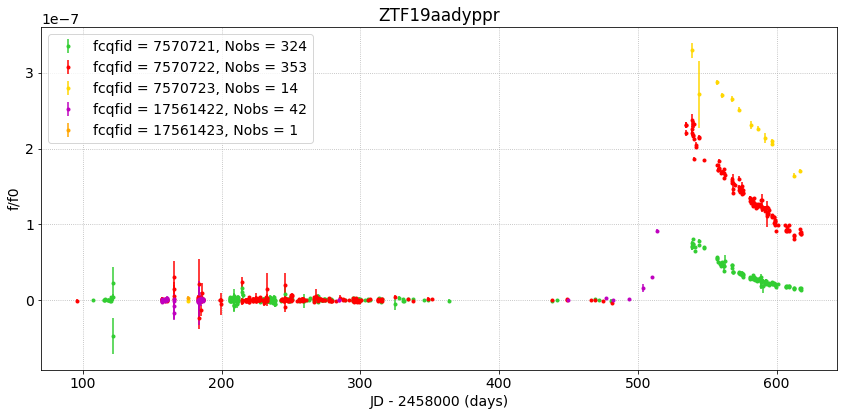

In [13]:
plotlcs(mylc, name, targetdir, seeing_cut = 7.)

A beautiful light curve!

## 8. Additional Stuff: how about some quality cuts?

In [18]:
len (mylc)

734

In [19]:
len (ipaclc)

649

You may find the number of observations of our light curve and that from IPAC's forced photometry service not exactly the same. This number can be very different especially if your target was observed in the commissioning phase of the survey (late 2017 and early 2018). IPAC's forced photometry light curve will __not__ extract commissioning data.

In [20]:
# for IPAC light curve: only retain those data points that are also in our light curve
ix13 = np.in1d(ipaclc['diffimgname'].values, mylc['diffimgname'].values)
ipaclc = ipaclc[ix13]

In [21]:
len (ipaclc)

645

In [22]:
ix31 = np.in1d(mylc['diffimgname'].values, ipaclc['diffimgname'].values)

In [23]:
np.sum(ix31)

645

In [24]:
infobitssci3 = np.zeros(len(mylc))
infobitssci3[ix31] = ipaclc['infobitssci'].values
mylc['infobitssci'] = infobitssci3

In [25]:
scisigpix3 = np.zeros(len(mylc))
scisigpix3[ix31] = ipaclc['scisigpix'].values    
mylc['scisigpix'] = scisigpix3

In [47]:
ixg = mylc["filterid"].values==1
ixr = mylc["filterid"].values==2
ixi = mylc["filterid"].values==3
ixk = np.any([mylc["infobitssci"].values!=0, 
              mylc["scisigpix"].values>25, 
              mylc["seeing"].values>4.5], axis=0)

In [48]:
time = mylc["jdobs"].values
flux = mylc["Fratio"].values
flux_unc = mylc["Fratio_unc"].values

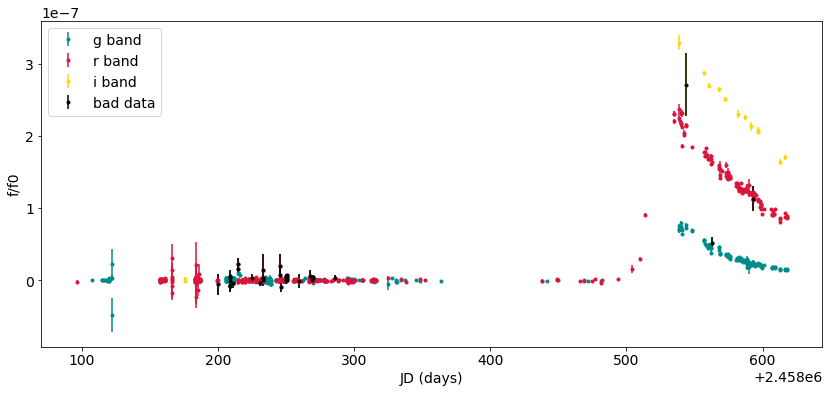

In [51]:

plt.figure(figsize=(14, 6))
plt.errorbar(time[ixg], flux[ixg], flux_unc[ixg], fmt=".", color="darkcyan", label="g band")
plt.errorbar(time[ixr], flux[ixr], flux_unc[ixr], fmt=".", color="crimson", label="r band")
plt.errorbar(time[ixi], flux[ixi], flux_unc[ixi], fmt=".", color="gold", label="i band")
plt.errorbar(time[ixk], flux[ixk], flux_unc[ixk], fmt=".", color="k", label="bad data")
plt.xlabel('JD (days)')
plt.ylabel('f/f0')
plt.legend()

In [52]:
mylc.to_csv(targetdir+"lightcurves/final_lightcurve_"+name+".csv")